In [1]:
!pip install opencv-python
!pip install scikit-image

from skimage import color, feature
from skimage.feature import hog
from skimage.io import imread
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl.metadata (14 kB)
Using cached scikit_image-0.24.0-cp312-cp312-win_amd64.whl (12.9 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Image :  (476, 458, 3)


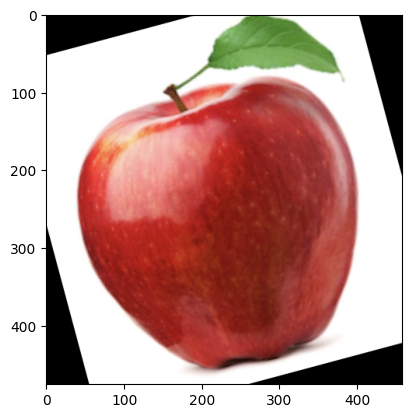

In [26]:
img=np.array(mpimg.imread('.gitignore/datasets/fruits-fresh-and-rotten/dataset/train/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 4.59.36 PM.png'))
img.setflags(write=1)
print('Image : ',img.shape)
plt.imshow(img)
plt.show()

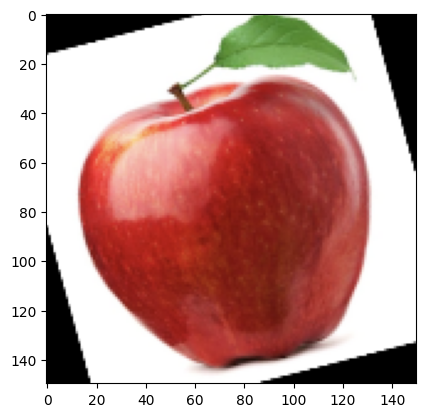

(150, 150, 3)


In [27]:
import cv2

# Redimensionar la imatge
resized_img = cv2.resize(img, (150, 150))

# Mostrar la imatge redimensionada
plt.imshow(resized_img)
plt.show()
print(resized_img.shape)

Nou tamany de la imatge per a poder ser procesada pel model d'aprenentatge més fàcilment. 

A continuació convertirem la imatge a RGB seleccionant només aquests canals, convertirem les imatges a una escala de grisos eliminant la complexitat dels colors i ens centrarem en l'estructura per a detectar formes i textures de les imatges mitjançant la tècnica HOG. 

(10404,)
[0. 0. 0. ... 0. 0. 0.]
(150, 150)


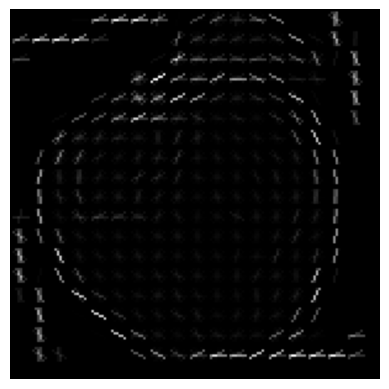

In [28]:
from skimage import color, feature
# Remove the alpha channel from the image
rgb_img = resized_img[:, :, :3]


# Convert the image to grayscale
gray_img = color.rgb2gray(rgb_img)

# Compute HOG features for the grayscale image
fd, hog_image = feature.hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True)

print(fd.shape)
print(fd)
print(hog_image.shape)
# Display the HOG image
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

**Procesament de imatges Fresh Apples:**

A través del Histogram of Oriented Objects podem extreure les característiques de les Fresh Apples

In [30]:
# Lista de características y etiquetas
data_freshapples = []
labels_freshapples = []

for entry in glob.glob(".gitignore/datasets/fruits-fresh-and-rotten/dataset/train/freshapples/*.png"):
    img = cv2.imread(entry)  # Leer imagen
    resized_img = cv2.resize(img, (64, 32))  # Redimensionar imagen
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    fd = hog(gray_img)  # Calcular características HOG
    data_freshapples.append(fd)  # Agregar características
    labels_freshapples.append('freshapple')  # Asignar etiqueta
print("Fresh Apples Images: " + str(len(data_freshapples)))

data_freshbanana = []
labels_freshbanana = []

for entry in glob.glob(".gitignore/datasets/fruits-fresh-and-rotten/dataset/train/freshbanana/*.png"):
    img = cv2.imread(entry)
    resized_img = cv2.resize(img, (64, 32))
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    fd = hog(gray_img)
    data_freshbanana.append(fd)
    labels_freshbanana.append('freshbanana')  # Asignar etiqueta
print("Fresh Bananas Images: " + str(len(data_freshbanana)))

data_freshoranges = []
labels_freshoranges = []

for entry in glob.glob(".gitignore/datasets/fruits-fresh-and-rotten/dataset/train/freshoranges/*.png"):
    img = cv2.imread(entry)
    resized_img = cv2.resize(img, (64, 32))
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    fd = hog(gray_img)
    data_freshoranges.append(fd)
    labels_freshoranges.append('freshorange')  # Asignar etiqueta
print("Fresh Oranges Images: " + str(len(data_freshoranges)))

# Unir todas las características y etiquetas
train_data = data_freshapples + data_freshbanana + data_freshoranges
train_label_list = labels_freshapples + labels_freshbanana + labels_freshoranges

# Verificar la longitud de los datos y las etiquetas
print("Total number of images: " + str(len(train_data)))
print("Total number of labels: " + str(len(train_label_list)))


Fresh Apples Images: 1693
Fresh Bananas Images: 1581
Fresh Oranges Images: 1466
Total number of images: 4740
Total number of labels: 4740


Tenim un total de 4740 imatges processades on cadascuna s'ha associat a una etiqueta de fruita específica, observem un conjunt de dades equilibrades on cadascuna de les classes té una quantitat similar d'imatges processades. 